In [1]:
from preprocess_data import *
from TDApipeline import *
from intensities_pipeline import *
from knn_pipeline import *
import scipy.io as sio
import os
import time  
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg as la
import numpy as np

def define_subject_dir(i_sub):
    """
    Creates the directory if it doesn't exist
    :param i_sub: subject id
    :return: directory path
    """
    res_dir = "results/intensities/subject_" + str(i_sub) +'/'
    if not os.path.exists(res_dir):
        print("create directory:", res_dir)
        os.makedirs(res_dir)
    return res_dir

def load_data(i_sub,space='both'):
    """
    Loads data from electrode space, font space 
    or both for a given subject
    :param i_sub: subject id
    :param space: electrode/font_space
    :return: data,directory path
    """
    subj_dir = define_subject_dir(i_sub)
    raw_data = sio.loadmat('data/dataClean-ICA3-'+str(i_sub)+'-T1.mat')
    
    if space=='electrodeSpace':
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        return elec_space,subj_dir
    elif space=='fontSpace':
        font_space=raw_data['ic_data3']
        return font_space,subj_dir
    else:
        elec_space=raw_data['dataSorted'] # [N,T,n_trials,motiv] 
        font_space=raw_data['ic_data3']
        return (elec_space,font_space),subj_dir,raw_data['indexM']

In [2]:
s,subj_dir=load_data(25,space='electrodeSpace')

In [3]:
electrodes_pos = np.load('results/intensities/xy_coord.npy')


In [4]:
electr_coord = pd.DataFrame(np.array([electrodes_pos[:, -1],
                                              electrodes_pos[:, 1].astype(float),
                                              electrodes_pos[:, 2].astype(float)]).T)


In [5]:
subj_dir

'results/intensities/subject_25/'

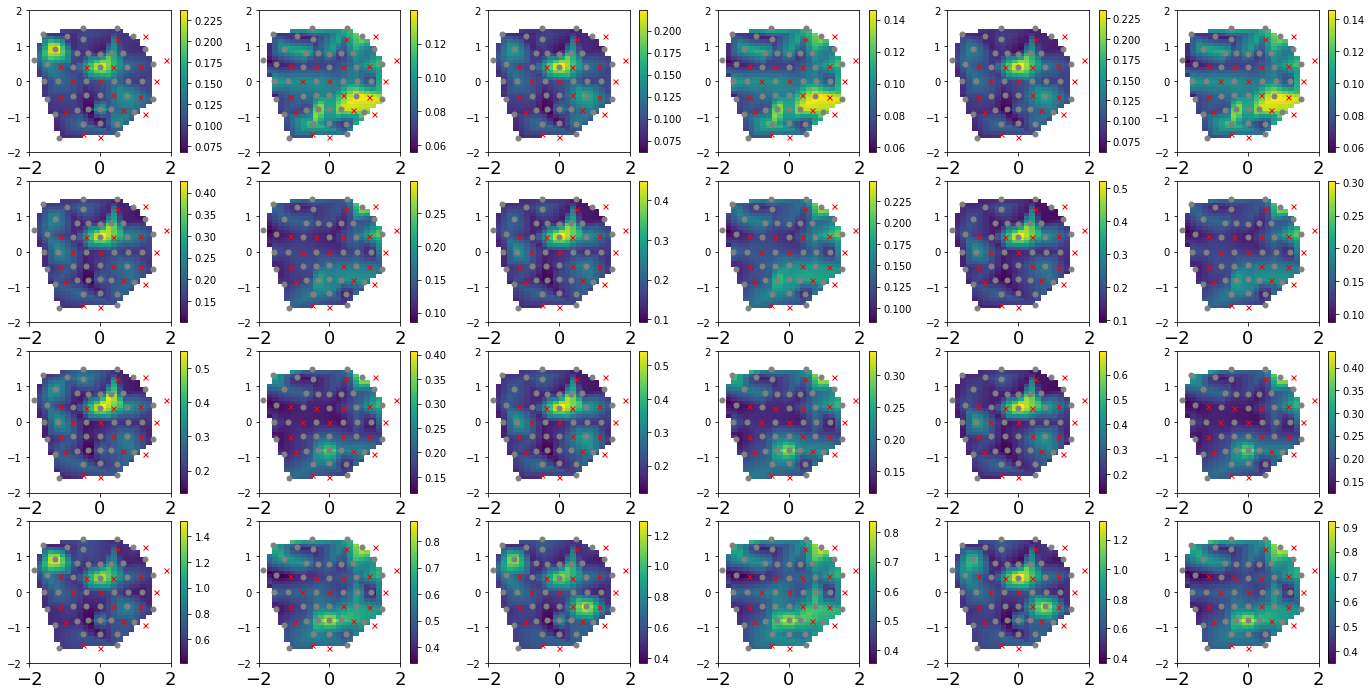

In [30]:
from scipy.interpolate import griddata

subjects=list(range(25,26)) 
bands=[-1,0,1,2] 
sessions=list(range(1,3))
spaces=['electrodeSpace']#,'fontSpace']
band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'} 
for subj in subjects:
    silent_chan = np.load('results/intensities/subject_'+str(subj)+'/silent-channels-'+str(subj)+'.npy')
    electr_coord['is_silent'] = silent_chan
    electr_coord.columns = ['electrode_name', 'x', 'y', 'is_silent']
    for space in spaces:
        fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24, 12))
        plt.rcParams['xtick.labelsize']=18
        for i_band in range(-1,3):
            for j in range(3):
                for ses in range(2):
                    
                    mean=np.load(subj_dir+space+'/'+band_dic[i_band]+'/session'+str(ses+1)+'/reprojected_means_m'+str(j)+'.npy')
                    
                    mean_df=pd.DataFrame(np.concatenate((np.array(electr_coord['electrode_name'])[~silent_chan].reshape(-1,1), mean.reshape(-1,1)),axis=1))
                    mean_df.columns = ['electrode_name', 'mean']
                    
                    plot_table=pd.merge(mean_df.assign(str_name=mean_df.electrode_name.astype(str)),
                                 electr_coord.assign(str_name=electr_coord.electrode_name.astype(str)),
                                 how='inner', on='electrode_name')[['electrode_name', 'is_silent', 'x', 'y',
                                                              'mean']]
                    
                    x = np.array(plot_table.x).astype(float)
                    xs = np.array(electr_coord[electr_coord.is_silent].x).astype(float)
                    y = np.array(plot_table.y).astype(float)
                    ys = np.array(electr_coord[electr_coord.is_silent].y).astype(float)
                    z = np.array(plot_table['mean']).astype(float)
                    
                    grid_x, grid_y = np.mgrid[-8:8:100j, -9:10:200j]
                    
                    points = np.array([x, y]).T
                    silent_points = np.array([xs, ys]).T
                    values = z

                    # plt.colorbar(im, ax=ax[i, j])interpolate
                    zi =griddata(points, values, (grid_x, grid_y), method='linear')

                
                    im=axes[i_band][2*j+ses].imshow(zi.T, extent=(-8.1, 8.1, -9.1, 10.1), origin='lower')
                    axes[i_band][2*j+ses].plot(points[:, 0], points[:, 1], 'o', ms=5, c='grey')
                    axes[i_band][2*j+ses].plot(silent_points[:, 0], silent_points[:, 1], 'x', ms=5, c='red')
                    axes[i_band][2*j+ses].set_xlim([-2, 2])
                    axes[i_band][2*j+ses].set_ylim([-2, 2])
                    plt.colorbar(im,ax=axes[i_band][2*j+ses])
                    
plt.show()

In [28]:
silent_points

array([], shape=(0, 2), dtype=float64)

In [34]:
x=np.random.rand(42)

x.shape

(42,)

In [28]:
~silent_chan

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True, False, False,  True, False,  True, False,
        True, False, False, False,  True,  True,  True, False, False,
        True, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True])

In [43]:
names=np.array(electr_coord['electrode_name'])
names=np.array(electr_coord['electrode_name'])[~silent_chan].reshape(-1,1)
names.shape

(42, 1)

In [48]:
prova=pd.DataFrame(np.concatenate((names, x.reshape(-1,1)),axis=1))
prova.columns = ['electrode_name', 'mean']


In [51]:
pd.merge(prova.assign(str_name=prova.electrode_name.astype(str)),
                                 electr_coord.assign(str_name=electr_coord.electrode_name.astype(str)),
                                 how='inner', on='electrode_name')[['electrode_name', 'is_silent', 'x', 'y',
                                                              'mean']]

,electrode_name,is_silent,x,y,mean
0,Fp1,False,-0.485328,1.493835,0.621165
1,Fp2,False,0.485501,1.493884,0.199683
2,F7,False,-1.270781,0.923319,0.479462
3,F3,False,-0.652084,0.812357,0.285096
4,Fz,False,0.0,0.785398,0.781399
5,F4,False,0.652084,0.812357,0.53584
6,F8,False,1.270781,0.923319,0.278715
7,T7,False,-1.570796,0.0,0.103346
8,C4,False,0.785398,0.000111,0.122867
9,F5,False,-1.596877,1.3295,0.883649
